# Garmin Sleep Analysis

Lets import the libraries we need.

In [3]:
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

## Data Extraction

Using Adam Brownell's function in his Gtihub repo located here, we can extract the sleep data from json file format into pandas dataframes.
https://github.com/adam1brownell/garmin_data/blob/main/garmin_functions.py

In [4]:
# _sleepData.json'
def build_sleep_data(file_name):
    """
    Take in ...sleepData.json file and output pandas
    Input:
        file_name | str
            _sleepData file
    Output
        sleep_pd | pdf
            pandas dataframe of sleep data
    """

    with open(file_name) as file:
        j = json.load(file)

    # These are must-have feautres for sleep sesh to count
    sleep_start = []
    sleep_end = []
    date = []

    for i in range(len(j)):
        sesh = j[i]
        sleep_start.append(pd.Timestamp(sesh['sleepStartTimestampGMT']))
        sleep_end.append(pd.Timestamp(sesh['sleepEndTimestampGMT']))
        date.append(sesh['calendarDate'])

    sleep_pd = pd.DataFrame({"startTimeGmt":sleep_start,"endTimeGmt":sleep_end,"date":date})

    # Add the 'spo2SleepSummary' column
    sleep_pd['spo2SleepSummary'] = np.nan
    
    # There are metrics that could be dropped by snapshot
    # hence the double loop
    sleep_pd['sleepWindowConfirmationType'] = np.nan
    sleep_pd['deepSleepSeconds'] = np.nan
    sleep_pd['lightSleepSeconds'] = np.nan
    sleep_pd['remSleepSeconds'] = np.nan
    sleep_pd['awakeSleepSeconds'] = np.nan
    sleep_pd['unmeasurableSeconds'] = np.nan
    sleep_pd['averageRespiration'] = np.nan
    sleep_pd['lowestRespiration'] = np.nan
    sleep_pd['highestRespiration'] = np.nan
    sleep_pd['retro'] = np.nan
    sleep_pd['awakeCount'] = np.nan
    sleep_pd['avgSleepStress'] = np.nan

    sleep_pd['overallScore'] = np.nan
    sleep_pd['qualityScore'] = np.nan
    sleep_pd['durationScore'] = np.nan
    sleep_pd['recoveryScore'] = np.nan
    sleep_pd['deepScore'] = np.nan
    sleep_pd['lightScore'] = np.nan
    sleep_pd['awakeningsCountScore'] = np.nan
    sleep_pd['awakeTimeScore'] = np.nan
    sleep_pd['combinedAwakeScore'] = np.nan
    sleep_pd['restfulnessScore'] = np.nan
    sleep_pd['feedback'] = np.nan
    sleep_pd['insight'] = np.nan
    
    #added manually
    #sleep_pd['spo2SleepSummary'] = np.nan

    for i in range(len(j)):
        sesh = j[i]
        for key, value in sesh.items():
            # Already good
            if key in ['sleepStartTimestampGMT','sleepEndTimestampGMT','calendarDate']:
                continue
            # Sleep Scores
            elif key == 'sleepScores':
                for sleep_key, score in sesh[key].items():
                    sleep_pd.loc[i,sleep_key] = score

            #elif key in sleep_pd.columns:
             #   sleep_pd.loc[i,key] = value
            elif key in sleep_pd.columns:
                # Check for data types and missing values before assignment
                column_dtype = sleep_pd.dtypes[key]
                if pd.api.types.is_numeric_dtype(column_dtype):
                    # Convert value to float (adjust if needed)
                    value = float(value)
                elif pd.api.types.is_bool_dtype(column_dtype):
                    # Convert value to boolean (adjust if needed)
                    value = bool(value)
                elif pd.api.types.is_string_dtype(column_dtype):
                    # Convert value to string (adjust if needed)
                    value = str(value)
            else:
                raise Exception(f"Adam didn't account for {key} metric in snapshot! Let him know!!")


    # Rename bc I hate this column phrasing
    sleep_pd = sleep_pd.rename(columns= {"averageRespiration":"respirationAvg",
                                "lowestRespiration":"respirationMin",
                                "highestRespiration":"respirationMax"})
    return(sleep_pd)

In [5]:
# _sleepData.json'
def build_sleep_data(file_name):
    """
    Take in ...sleepData.json file and output pandas
    Input:
        file_name | str
            _sleepData file
    Output
        sleep_pd | pdf
            pandas dataframe of sleep data
    """
    with open(file_name) as file:
        data = json.load(file)

    df = pd.DataFrame(data)
    
    return(df)

Lets now load all the json files in the local directory and append them together into a pandas dataframe using the function above.

In [6]:
cwd = os.getcwd()
cwd

'C:\\Users\\jrwoo\\Documents'

In [7]:
path_to_json = cwd
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
json_files

['2021-08-29_2021-12-07_96604052_sleepData.json',
 '2021-12-07_2022-03-17_96604052_sleepData.json',
 '2022-03-17_2022-06-25_96604052_sleepData.json',
 '2022-06-25_2022-10-03_96604052_sleepData.json',
 '2022-10-03_2023-01-11_96604052_sleepData.json',
 '2023-01-11_2023-04-21_96604052_sleepData.json',
 '2023-04-21_2023-07-30_96604052_sleepData.json']

## Data Cleaning

In [8]:
import pandas as pd

df_all = pd.DataFrame()
for i in json_files:
    df = build_sleep_data(i)
    df_all = pd.concat([df_all, df], axis = 0)
    
df_all

# Remove rows where 'sleepWindowConfirmationType' is 'UNCONFIRMED'
#df_all = df_all[df_all['sleepWindowConfirmationType'] != 'UNCONFIRMED']

# Convert 'sleepStartTimestampGMT' to pandas Timestamp
df_all['sleepStartTimestampGMT'] = pd.to_datetime(df_all['sleepStartTimestampGMT'])
df_all['sleepEndTimestampGMT'] = pd.to_datetime(df_all['sleepEndTimestampGMT'])

# Localize the 'sleepStartTimestampGMT' and 'sleepEndTimestampGMT' to GMT timezone
gmt_tz = 'GMT'
df_all['sleepStartTimestampGMT'] = df_all['sleepStartTimestampGMT'].dt.tz_localize(gmt_tz)
df_all['sleepEndTimestampGMT'] = df_all['sleepEndTimestampGMT'].dt.tz_localize(gmt_tz)

# Convert to Chicago time (CST)
chicago_tz = 'America/Chicago'
df_all['sleepStartTimestampCST'] = df_all['sleepStartTimestampGMT'].dt.tz_convert(chicago_tz).dt.tz_localize(None)
df_all['sleepEndTimestampCST'] = df_all['sleepEndTimestampGMT'].dt.tz_convert(chicago_tz).dt.tz_localize(None)

# If you want to drop the original GMT columns
df_all.drop(columns=['sleepStartTimestampGMT', 'sleepEndTimestampGMT', 'spo2SleepSummary','retro','unmeasurableSeconds'], inplace=True)

# Reorder the columns so that 'sleepStartTimestampCST' and 'sleepEndTimestampCST' come first
new_column_order = ['sleepStartTimestampCST', 'sleepEndTimestampCST'] + [col for col in df_all.columns if col not in ['sleepStartTimestampCST', 'sleepEndTimestampCST']]
df_all = df_all[new_column_order]

df_all

,sleepStartTimestampCST,sleepEndTimestampCST,calendarDate,sleepWindowConfirmationType,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds
0,2021-11-30 23:40:00,2021-12-01 08:40:00,2021-12-01,UNCONFIRMED,NaN,NaN,NaN,NaN
1,2021-12-01 23:59:00,2021-12-02 09:56:00,2021-12-02,MANUALLY_CONFIRMED,2640.0,25020.0,5820.0,2340.0
2,2021-12-02 21:52:00,2021-12-03 09:25:00,2021-12-03,ENHANCED_CONFIRMED_FINAL,5040.0,25920.0,9240.0,1380.0
3,2021-12-04 00:52:00,2021-12-04 08:40:00,2021-12-04,MANUALLY_CONFIRMED,0.0,20160.0,6720.0,1200.0
4,2021-12-05 00:58:00,2021-12-05 09:16:00,2021-12-05,ENHANCED_CONFIRMED_FINAL,4980.0,15600.0,9240.0,60.0
...,...,...,...,...,...,...,...,...
95,2023-07-25 01:30:00,2023-07-25 11:13:00,2023-07-25,MANUALLY_CONFIRMED,5820.0,23940.0,5160.0,60.0
96,2023-07-26 01:32:00,2023-07-26 10:34:00,2023-07-26,MANUALLY_CONFIRMED,15660.0,16080.0,NaN,780.0
97,2023-07-27 02:57:00,2023-07-27 10:42:00,2023-07-27,MANUALLY_CONFIRMED,3600.0,16620.0,7560.0,120.0
98,2023-07-28 01:10:00,2023-07-28 11:02:00,2023-07-28,ENHANCED_CONFIRMED_FINAL,6240.0,20280.0,8760.0,240.0


In [9]:
# Save the DataFrame 'df_all' as a CSV file
df_all.to_csv('sleepData.csv', index=False)

Lets visualise the empty rows and columns using Seaborn.

<AxesSubplot:>

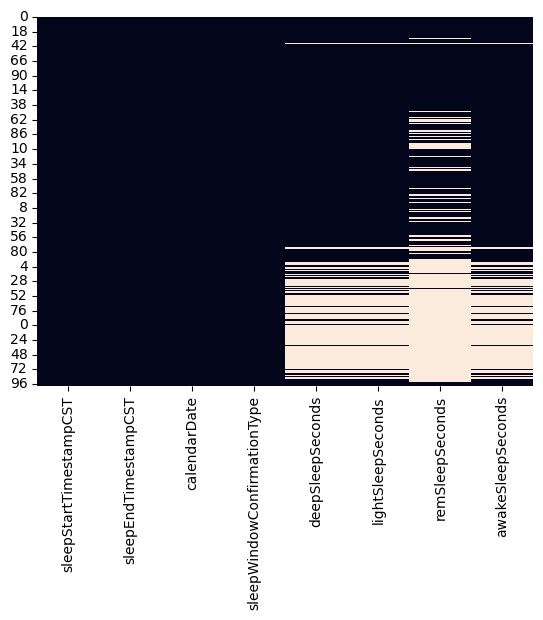

In [11]:
sns.heatmap(df_all.isnull(), cbar=False)

In [15]:
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse(cwd+"/export.xml")
root = tree.getroot()

C:\Users\jrwoo\Documents


In [43]:
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse(cwd+"/export.xml")
root = tree.getroot()

# Initialize lists to hold data
records = []
columns = ["SourceName", "StartDate", "EndDate", "TimeZone"]

# Extract data from the XML file
for record in root.findall(".//Record"):
    if record.get("type") == "HKCategoryTypeIdentifierSleepAnalysis":
        time_zone_element = record.find(".//MetadataEntry[@key='HKTimeZone']")
        if time_zone_element is not None:
            time_zone = time_zone_element.get("value")
        else:
            time_zone = None
        record_data = {
            "SourceName": record.get("sourceName"),
            "StartDate": record.get("startDate"),
            "EndDate": record.get("endDate"),
            "TimeZone": time_zone
        }
        records.append(record_data)
        
# Create a pandas DataFrame
df = pd.DataFrame(records, 
                  columns=columns)

# Print the DataFrame
df


,SourceName,StartDate,EndDate,TimeZone
0,Clock,2016-12-29 22:45:04 -0500,2016-12-30 06:11:34 -0500,America/New_York
1,Clock,2017-01-02 22:56:16 -0500,2017-01-03 05:47:24 -0500,America/New_York
2,Clock,2017-06-26 23:00:00 -0500,2017-06-27 06:41:52 -0500,America/Chicago
3,Clock,2017-06-27 06:42:08 -0500,2017-06-27 07:12:24 -0500,America/Chicago
4,Clock,2017-06-27 23:00:08 -0500,2017-06-28 07:10:55 -0500,America/Chicago
...,...,...,...,...
4238,Connect,2023-07-30 03:08:00 -0500,2023-07-30 11:01:00 -0500,None
4239,iPhone,2023-07-31 00:31:43 -0500,2023-07-31 08:30:03 -0500,America/Chicago
4240,iPhone,2023-08-01 01:25:13 -0500,2023-08-01 02:00:13 -0500,America/Chicago
4241,iPhone,2023-08-01 02:37:19 -0500,2023-08-01 08:30:01 -0500,America/Chicago


In [44]:
# Convert to datetime
df["SleepStartTimestamp"] = pd.to_datetime(df["StartDate"])
df["SleepEndTimestamp"] = pd.to_datetime(df["EndDate"])

# Get the day awakening
df['Date'] = df['SleepEndTimestamp'].dt.date

df = df.drop(columns=['StartDate','EndDate'])

######## Filter df for only dates between '06/11/2021' and '07/29/2023'

# Create a mask for filtering the DataFrame
start_date = pd.to_datetime('06/11/2021').date()
end_date = pd.to_datetime('07/29/2023').date()
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)

# Filter the DataFrame using the mask
df = df[mask]

df

,SourceName,TimeZone,SleepStartTimestamp,SleepEndTimestamp,Date
1348,iPhone,America/Chicago,2021-06-11 00:03:33-05:00,2021-06-11 07:30:16-05:00,2021-06-11
1349,iPhone,America/Chicago,2021-06-14 00:28:14-05:00,2021-06-14 07:24:03-05:00,2021-06-14
1350,iPhone,America/Chicago,2021-06-15 01:02:12-05:00,2021-06-15 06:55:10-05:00,2021-06-15
1351,iPhone,America/Chicago,2021-06-16 00:47:47-05:00,2021-06-16 07:30:09-05:00,2021-06-16
1352,iPhone,America/Chicago,2021-06-17 00:15:24-05:00,2021-06-17 07:30:11-05:00,2021-06-17
...,...,...,...,...,...
4230,Connect,None,2023-07-29 08:06:00-05:00,2023-07-29 08:13:00-05:00,2023-07-29
4231,Connect,None,2023-07-29 08:16:00-05:00,2023-07-29 08:19:00-05:00,2023-07-29
4232,Connect,None,2023-07-29 08:33:00-05:00,2023-07-29 11:25:00-05:00,2023-07-29
4233,Connect,None,2023-07-29 03:19:00-05:00,2023-07-29 11:52:00-05:00,2023-07-29


In [45]:
# Find dates with multiples (duplicates)
duplicate_dates = df[df.duplicated(subset='Date', keep=False)]

# Print the dates with multiples
print(duplicate_dates)

     SourceName          TimeZone       SleepStartTimestamp  \
1354     iPhone  America/New_York 2021-06-27 23:30:00-05:00   
1355     iPhone  America/New_York 2021-06-28 07:22:29-05:00   
1357     iPhone  America/New_York 2021-06-29 23:30:00-05:00   
1358     iPhone  America/New_York 2021-06-30 07:27:30-05:00   
1360     iPhone  America/New_York 2021-07-05 00:14:49-05:00   
...         ...               ...                       ...   
4230    Connect              None 2023-07-29 08:06:00-05:00   
4231    Connect              None 2023-07-29 08:16:00-05:00   
4232    Connect              None 2023-07-29 08:33:00-05:00   
4233    Connect              None 2023-07-29 03:19:00-05:00   
4234    Connect              None 2023-07-29 11:26:00-05:00   

             SleepEndTimestamp        Date  
1354 2021-06-28 07:18:35-05:00  2021-06-28  
1355 2021-06-28 07:22:54-05:00  2021-06-28  
1357 2021-06-30 07:23:25-05:00  2021-06-30  
1358 2021-06-30 07:29:33-05:00  2021-06-30  
1360 2021-07-05 07

In [50]:
# Group by 'Date' and aggregate 'SleepStartTimestamp' and 'SleepEndTimestamp'
simplified_df = df.groupby('Date').agg({
    'SourceName': 'first',
    'TimeZone': 'first',
    'SleepStartTimestamp': 'min',
    'SleepEndTimestamp': 'max'
}).reset_index()

# Remove timezone from timestamps
simplified_df['SleepStartTimestamp'] = simplified_df['SleepStartTimestamp'].dt.tz_localize(None)
simplified_df['SleepEndTimestamp'] = simplified_df['SleepEndTimestamp'].dt.tz_localize(None)


# Print DataFrame
simplified_df

,Date,SourceName,TimeZone,SleepStartTimestamp,SleepEndTimestamp
0,2021-06-11,iPhone,America/Chicago,2021-06-11 00:03:33,2021-06-11 07:30:16
1,2021-06-14,iPhone,America/Chicago,2021-06-14 00:28:14,2021-06-14 07:24:03
2,2021-06-15,iPhone,America/Chicago,2021-06-15 01:02:12,2021-06-15 06:55:10
3,2021-06-16,iPhone,America/Chicago,2021-06-16 00:47:47,2021-06-16 07:30:09
4,2021-06-17,iPhone,America/Chicago,2021-06-17 00:15:24,2021-06-17 07:30:11
...,...,...,...,...,...
690,2023-07-25,Connect,America/Chicago,2023-07-25 00:30:25,2023-07-25 11:13:00
691,2023-07-26,Connect,America/Chicago,2023-07-26 01:19:31,2023-07-26 13:19:00
692,2023-07-27,Connect,America/Chicago,2023-07-27 02:14:01,2023-07-27 10:42:00
693,2023-07-28,Connect,America/Chicago,2023-07-28 00:49:36,2023-07-28 11:02:00


In [51]:
# Save DataFrame as CSV
simplified_df.to_csv('sleep_iPhoneHealth.csv', index=False)